# ResNet Model for CIFAR-10 Image Classification
## Deep Learning Mini Project

### Team: SPK
Sarthak Gupta (sg8304) &emsp; Pratik Pattanaik (pp2861) &emsp; Krish Panchal (khp3878)

## Training the model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms.v2 as v2

from torch.utils.data import Dataset, DataLoader

import time

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


### Prepare Data
Download train and test CIFAR-10 data and create dataloaders for them.
Also use data augmentaion and normalization specific for this dataset.

In [40]:
#downloading the dataset and dividing into test and train
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train = v2.Compose([
    v2.RandomCrop(32, padding = 4),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(*stats,inplace=True)
])

test = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(*stats)
])

# MixUp and CutMix
NUM_CLASSES=10
cutmix = v2.CutMix(alpha=0.5, num_classes=NUM_CLASSES)
mixup = v2.MixUp(alpha=0.4, num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = train)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4)

Files already downloaded and verified
Files already downloaded and verified


### Define Model
Code for our model with best results has been adapted from the following github [repo](https://github.com/Nikunj-Gupta/Efficient_ResNets). We have used same hyperparameters as mentioned in their config for best model.

In [4]:
# Efficient ResNet Model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_kernel_size=3, shortcut_kernel_size=1, drop=0.4):
        """
        Convolutional Layer kernel size Fi 
        Skip connection (shortcut) kernel size Ki 
        """
        super(BasicBlock, self).__init__()
        self.drop = drop 
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=conv_kernel_size, stride=stride, padding=int(conv_kernel_size/2), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=conv_kernel_size,stride=1, padding=int(conv_kernel_size/2), bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=shortcut_kernel_size, stride=stride, padding=int(shortcut_kernel_size/2), bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        if self.drop: self.dropout = nn.Dropout(self.drop)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        if self.drop: out = self.dropout(out)
        return out



def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.
    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    """
    def __init__(self,
                 channels,
                 reduction=16):
        super(SEBlock, self).__init__()
        mid_cannels = channels // reduction

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_cannels,
            bias=True)
        self.activ = nn.ReLU(inplace=True) 

        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class ResNet(nn.Module):
    def __init__(
            self, 
            block, 
            num_blocks, 
            conv_kernel_sizes=None, 
            shortcut_kernel_sizes=None,
            num_classes=10, 
            num_channels=32, 
            avg_pool_kernel_size=4, 
            drop=None, 
            squeeze_and_excitation=None):
        super(ResNet, self).__init__()
        self.in_planes = num_channels
        # self.avg_pool_kernel_size = avg_pool_kernel_size 
        self.avg_pool_kernel_size = int(32 / (2**(len(num_blocks)-1)))
        
        """
        # of channels Ci 
        """
        self.num_channels = num_channels
        self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels) 

        self.drop = drop 
        self.squeeze_and_excitation = squeeze_and_excitation 

        if self.squeeze_and_excitation: 
            self.seblock = SEBlock(channels=self.num_channels) 

        """
        # of Residual Layers N 
        # of Residual Blocks Bi 
        """
        self.residual_layers = [] 
        for n in range(len(num_blocks)): 
            stride = 1 if n==0 else 2 # stride=1 for first residual layer, and stride=2 for the remaining layers 
            conv_kernel_size = conv_kernel_sizes[n] if conv_kernel_sizes else 3 # setting default kernel size of block's convolutional layers 
            shortcut_kernel_size = shortcut_kernel_sizes[n] if shortcut_kernel_sizes else 1 # setting default kernel size of block's skip connection (shortcut) layers 
            self.residual_layers.append(self._make_layer(
                                                    block, 
                                                    self.num_channels*(2**n), 
                                                    num_blocks[n], 
                                                    stride=stride, 
                                                    conv_kernel_size=conv_kernel_size, 
                                                    shortcut_kernel_size=shortcut_kernel_size)) 

        self.residual_layers = nn.ModuleList(self.residual_layers)
        self.linear = nn.Linear(self.num_channels*(2**n)*block.expansion, num_classes) 
        """
        Dropout layer 
        """
        if self.drop: 
            self.dropout = nn.Dropout(self.drop) # Define proportion or neurons to dropout

    def _make_layer(self, block, planes, num_blocks, stride, conv_kernel_size, shortcut_kernel_size):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, conv_kernel_size, shortcut_kernel_size, drop=self.drop))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.squeeze_and_excitation: out = self.seblock(out) 
        for layer in self.residual_layers: 
            out = layer(out)         
        """
        Average pool kernel size 
        """
        out = F.avg_pool2d(out, self.avg_pool_kernel_size)
        out = out.view(out.size(0), -1)
        if self.drop: out = self.dropout(out)
        out = self.linear(out)
        return out


def efficient_resnet_model(config=None): 
    # Best Model 
    net =  ResNet(
            block=BasicBlock, 
            num_blocks=[4, 4, 3],                          # N: number of Residual Layers | Bi:Residual blocks in Residual Layer i 
            conv_kernel_sizes=[3, 3, 3],            # Fi: Conv. kernel size in Residual Layer i 
            shortcut_kernel_sizes=[1, 1, 1] ,    # Ki: Skip connection kernel size in Residual Layer i 
            num_channels=64,                      # Ci: # channels in Residual Layer i 
            avg_pool_kernel_size=8,      # P: Average pool kernel size 
            drop=0,                                      # use dropout with drop proportion 
            squeeze_and_excitation=1   # Enable/disable Squeeze-and-Excitation Block 
        ) 
    
    return net

### Define Optimizer
We have used the Lookahead Optimizer implementation from the same [repo](https://github.com/Nikunj-Gupta/Efficient_ResNets) as for the model

In [5]:
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import torch
import warnings

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0
    
    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)
    
    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def zero_grad(self):
        self.optimizer.zero_grad()
        
    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

Initialize the model and print summary

In [44]:
model = efficient_resnet_model()
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (seblock): SEBlock(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
    (activ): ReLU(inplace=True)
    (conv2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (residual_layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_siz

#### Check number of parameters
Print the number of trainable parameters in this model.

In [45]:
# To find the trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 4697742


Initialize the Loss, Lookahead optimizer and Scheduler for 200 epochs

In [46]:
#defining the loss and optimizer function
n_epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,
                          nesterov=True, momentum=0.9, weight_decay=0.0005)
optimizer = Lookahead(optimizer, k=5, alpha=0.5) # Initialize Lookahead 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

optimizer

Lookahead (
Parameter Group 0
    counter: 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.1
    lr: 0.1
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)

In [47]:
PATH = './models'
history = {
    'train_losses':[],
    'valid_losses':[],
    'valid_accuracies':[],
    'lr_list':[],
    'epochs':[],
    'best_accuracy':0
}

### Define training procedure
Here we are saving the model with best accuracy on validation data (**best_model**) and also the model after all the epochs are run (**latest_model**).

We are using gradient clipping to stabilize training.
We also use cutmix_or_mixup during finetuning to improve generalization capability of our model.

In [48]:
def training(model, optimizer, train_loader, test_loader, n_epochs, history, use_cutmix_or_mixup=False, previous_epoch=0, PATH = './models'):
    PATH = './models'
    epochs= n_epochs
    grad_clip = 0.1
    if use_cutmix_or_mixup:
        print("Using CutMix and MixUp for regularization")
    for e in range(epochs):
        train_loss=0.0
        valid_loss=0.0
        train_time = 0
        train_acc=[]
        test_acc = 0.0
        time_start = time.perf_counter()
        
        model.train()
        for images,labels in train_loader:
            if use_cutmix_or_mixup:
                images, labels = cutmix_or_mixup(images, labels)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps=model(images)
            loss=criterion(log_ps,labels)
            train_loss+=loss.item()*images.size(0)

            loss.backward()
            if grad_clip: 
                    nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
        time_train = time.perf_counter()
        
        model.eval()
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item() * images.size(0)

            prediction = torch.argmax(output, dim=1)
            k=torch.sum(prediction == labels)
            test_acc += k.item()
        time_eval = time.perf_counter()
        training_time = time_train- time_start
        evaluation_time = time_eval-time_train

        history['lr_list'].append(scheduler.get_last_lr())

        scheduler.step()

        train_loss=train_loss/len(train_loader.sampler)
        history['train_losses'].append(train_loss)

        valid_loss=valid_loss/len(test_loader.sampler)
        history['valid_losses'].append(valid_loss)
        
        accuracy = 100*test_acc/len(test_loader.sampler)
        history['valid_accuracies'].append(accuracy)
        
        history['epochs'].append(e+1+previous_epoch)

        if history['best_accuracy'] < accuracy:
            torch.save(model.state_dict(), PATH+'/best_model')
            history['best_accuracy']=accuracy

        print('epoch:{}  train loss :{:.6f}\t valid loss :{:.6f}\t validation accuracy :{:.2f}\t train time :{:.2f}\t eval time :{:.2f}'.format(
              e+1,
              train_loss,
    #           train_loss_with_l1,
              valid_loss,
              accuracy,
              training_time,
              evaluation_time

          ))

    torch.save(model.state_dict(), PATH+'/latest_model')
    return model, history

### Start Training
Train the model for 200 epochs first as mentioned in the Efficient ResNets repo but with [CutMix and MixUp](https://pytorch.org/vision/master/auto_examples/transforms/plot_cutmix_mixup.html) data augmentation enabled 

In [49]:
n_epochs=200
model, history = training(model, optimizer, train_loader, test_loader, n_epochs, history, True)

Using CutMix and MixUp for regularization
epoch:1  train loss :1.942002	 valid loss :1.367911	 validation accuracy :51.06	 train time :45.98	 eval time :14.27
epoch:2  train loss :1.643984	 valid loss :1.233274	 validation accuracy :56.06	 train time :46.51	 eval time :14.24
epoch:3  train loss :1.460310	 valid loss :1.150131	 validation accuracy :59.94	 train time :45.89	 eval time :14.09
epoch:4  train loss :1.381779	 valid loss :1.069694	 validation accuracy :64.12	 train time :46.13	 eval time :14.57
epoch:5  train loss :1.308993	 valid loss :1.008197	 validation accuracy :65.71	 train time :46.13	 eval time :14.45
epoch:6  train loss :1.197059	 valid loss :0.644188	 validation accuracy :79.38	 train time :46.37	 eval time :14.81
epoch:7  train loss :1.184723	 valid loss :0.617045	 validation accuracy :81.50	 train time :46.28	 eval time :14.02
epoch:8  train loss :1.134582	 valid loss :0.642562	 validation accuracy :79.93	 train time :46.44	 eval time :14.55
epoch:9  train loss :1

epoch:71  train loss :0.873366	 valid loss :0.335100	 validation accuracy :91.63	 train time :46.51	 eval time :13.86
epoch:72  train loss :0.851581	 valid loss :0.354113	 validation accuracy :91.37	 train time :46.54	 eval time :13.83
epoch:73  train loss :0.860085	 valid loss :0.453476	 validation accuracy :87.30	 train time :46.37	 eval time :13.82
epoch:74  train loss :0.883543	 valid loss :0.391133	 validation accuracy :89.23	 train time :46.37	 eval time :14.01
epoch:75  train loss :0.836507	 valid loss :0.399648	 validation accuracy :89.50	 train time :46.49	 eval time :13.88
epoch:76  train loss :0.840252	 valid loss :0.278436	 validation accuracy :92.42	 train time :46.33	 eval time :13.85
epoch:77  train loss :0.849741	 valid loss :0.352346	 validation accuracy :91.76	 train time :46.38	 eval time :14.17
epoch:78  train loss :0.858152	 valid loss :0.352785	 validation accuracy :92.40	 train time :46.68	 eval time :13.91
epoch:79  train loss :0.884647	 valid loss :0.422015	 va

epoch:141  train loss :0.717266	 valid loss :0.259314	 validation accuracy :95.04	 train time :47.08	 eval time :14.03
epoch:142  train loss :0.687428	 valid loss :0.249621	 validation accuracy :93.74	 train time :46.69	 eval time :14.06
epoch:143  train loss :0.680448	 valid loss :0.254223	 validation accuracy :94.45	 train time :46.73	 eval time :14.06
epoch:144  train loss :0.741852	 valid loss :0.227157	 validation accuracy :94.41	 train time :46.95	 eval time :14.27
epoch:145  train loss :0.662635	 valid loss :0.301919	 validation accuracy :94.46	 train time :46.73	 eval time :14.22
epoch:146  train loss :0.673979	 valid loss :0.235294	 validation accuracy :95.44	 train time :47.13	 eval time :14.49
epoch:147  train loss :0.666027	 valid loss :0.209551	 validation accuracy :95.49	 train time :47.41	 eval time :14.30
epoch:148  train loss :0.705910	 valid loss :0.199425	 validation accuracy :95.48	 train time :47.03	 eval time :14.76
epoch:149  train loss :0.680336	 valid loss :0.2

KeyboardInterrupt: 

In [ ]:
# Print best accuracy on validation data
print(history['best_accuracy'])

Check final training and validation data accuracy of trained model

In [13]:
# # train accuracy
# train_acc = 0.0
# for images,labels in train_loader:
#     images, labels = images.to(device), labels.to(device)
#     with torch.no_grad():
#         outputs = model(images)
#         prediction = torch.argmax(outputs, dim=1)
#         k=torch.sum(prediction == labels)
#         train_acc += k.item()

# train_acc = 100*train_acc/len(train_dataset)
# print(f'train accuracy: {train_acc}',)

train accuracy: 100.0


In [14]:
# # test accuracy
# test_acc = 0.0
# for images,labels in test_loader:
#     images, labels = images.to(device), labels.to(device)
#     with torch.no_grad():
#         outputs = model(images)
#         prediction = torch.argmax(outputs, dim=1)
#         k=torch.sum(prediction == labels)
#         test_acc += k.item()

# test_acc = 100*test_acc/len(test_dataset)
# print(f'test accuracy: {test_acc}',)

test accuracy: 95.73


Plot training and validation loss while training

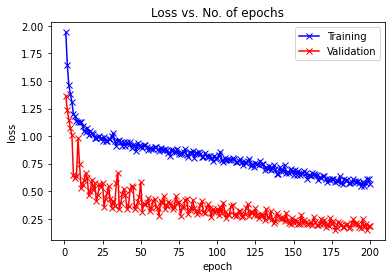

In [50]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.plot(epochs, train_losses, '-bx')
    plt.plot(epochs, valid_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history['train_losses'], history['valid_losses'], history['epochs'])

Plot validation accuracies while training

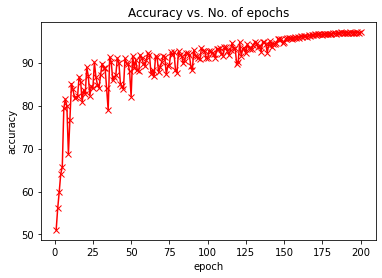

In [51]:
def plot_accuracies(valid_accuracies, epochs):
    plt.plot(epochs,valid_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history['valid_accuracies'], history['epochs'])

Plot how the learning rate is changing with epochs.

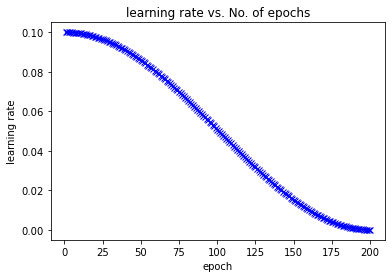

In [52]:
def plot_learning_rates(lr_list, epochs):
    plt.plot(epochs, lr_list, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.title('learning rate vs. No. of epochs');
plot_learning_rates(history['lr_list'], history['epochs'])

Plot average accuracy for 10 epoch intervals for all training epochs

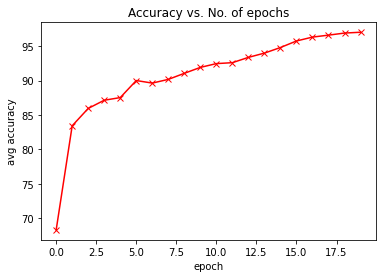

In [53]:
def plot_avg_accuracies(avg_accuracies):
    plt.plot(avg_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('avg accuracy')
    plt.title('Accuracy vs. No. of epochs');

overall_valid_accuracies = history['valid_accuracies']
avg_accuracies = [math.fsum(overall_valid_accuracies[i*10:i*10+10])/10 for i in range(len(overall_valid_accuracies)//10)]

plot_avg_accuracies(avg_accuracies)

With this configuration we were able to reach **0.883** score on kaggle on no labeled data.

## Prediction on Unlabelled Data

### Data Loading

This part of the notebook was adapted from the starter [notebook](https://www.kaggle.com/competitions/deep-learning-mini-project-spring-24-nyu/discussion) given on kaggle.

For this keep the unlabeled data "*cifar_test_nolabels.pkl*" file in same directory as this notebook

In [54]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('cifar_test_nolabels.pkl')

# # Extract images
# images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 

Let's see starting few images in unlabeled data

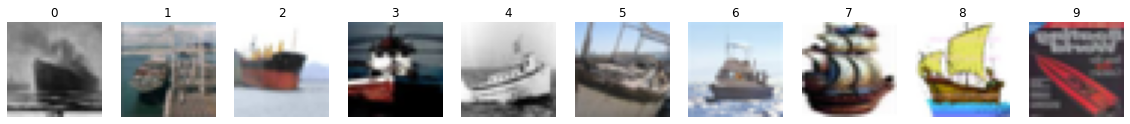

In [55]:
# Extract images and convert back to image format
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.title(i)
    plt.axis('off')
plt.show()

Looks like first 10 images are all ships

Create Pytorch Dataset and Dataloader for unlabeled dataset

In [56]:
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]        
        if self.transform:
            image = Image.fromarray(x)
            x = self.transform(x)
        return x, index
    
    def __len__(self):
        return len(self.data)

unlabeled_dataset = MyDataset(images, transform=test)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=100)
print(len(unlabeled_dataset))
print(len(unlabeled_dataloader))

10000
100


Load the model with best accuracy for doing inference on unlabeled data, we can also check it's accuracy on validation data and also verify number of parameters once more

In [57]:
best_model= efficient_resnet_model()

best_model.load_state_dict(torch.load(PATH+'/best_model')) # to use latest model use (PATH+'/latest_model') instead
best_model.eval()
best_model = best_model.to(device)

test_acc = 0.0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = best_model(images)
        prediction = torch.argmax(outputs, dim=1)
        k=torch.sum(prediction == labels)
        test_acc += k.item()
        val = 100*(k/len(images))

test_acc = 100*test_acc/len(test_dataset)
print(f'test accuracy: {test_acc}')

total_params = sum(p.numel() for p in best_model.parameters())
print(f"Number of parameters: {total_params}")

test accuracy: 97.08
Number of parameters: 4697742


Let's perform prediction on unlabeled dataset

In [58]:
# x, idx = unlabeled_dataset[0]
pred_list = []
idx_list = []
i =1
for x, idx in unlabeled_dataloader:
    x = x.to(device)
    outputs = best_model(x)
    _, predicted_classes = torch.max(outputs, 1)

    predicted_classes =predicted_classes.to('cpu')
    idx = idx.to('cpu')
    pred_list = pred_list + predicted_classes.tolist()
    idx_list = idx_list + idx.tolist()
    del x


In [37]:
# Let's check the predictions for first 10 images, they should all be ships
print(pred_list[0:10])

[8, 8, 8, 8, 8, 8, 8, 1, 8, 8]


CIFAR-10 has following label class combination:
0:airplane, 1:automobile, 2:bird, 3:cat, 4:deer, 5:dog, 6:frog, 7:horse, 8:ship, 9:truck
as per this above predictions look good, there is only one wrong prediction.

Now, we can save the predictions in a csv file for submission

In [59]:
import csv

# Open a new CSV file in write mode
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['ID', 'Labels'])
    
    # Write the data rows
    for idx, pred in zip(idx_list, pred_list):
        writer.writerow([idx, pred])

In [60]:
# Clear GPU cache memory
torch.cuda.empty_cache()

## Final result
With these predictions we were able to get **0.883** score on unlabeled data on kaggle.

### Fin